In [1]:
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import tripy

from to3D import *
from toOBJ import *
plt.style.use('classic')

In [2]:
loc="./examples/moonridge.json"
file=open(loc,"r")
data=json.loads(file.read())
print(data["features"][0])
towerRadius=data["features"][0]["towerRadius"]
wallThickness=data["features"][0]["wallThickness"]
roadWidth=data["features"][0]["roadWidth"]

{'type': 'Feature', 'id': 'values', 'roadWidth': 8, 'towerRadius': 7.6, 'wallThickness': 7.6, 'generator': 'mfcg', 'version': '0.8.0', 'riverWidth': 31.357382526694515}


## Walls
Extracting wall data is easy, it's just a contour

We need to make towers at each vertex. Some roads pass through the walls!
=> they always pass exactly ON a vertex of the contour
    => we can search for the presence of the same vertex in road data
    => if found, we need to make room for the road + for the tower.
2 solutions for the contour that we will elevate using the same code as for building:
- use a contour for each segment, use a circle for each vertex
- use one contour for door-to-door segment
- - use road-like way to create the contour of the segments
- - requires to create a part of a circle in the right order for the vertices

I think it's better for customisation to keep it simple: one contour for each segment, one contour for each tower


In [3]:

roads=data["features"][2]["geometries"]
walls=data["features"][3]["geometries"]
#for each segment of the wall check if it intersect with one of the roads 

def getCityWallsAndTowersContour(roads,walls,wT,tR):
    wallSegs=getWallSegs(roads,walls,tR)
    walls=[]
    towers=[]
    for seg in wallSegs:
        xr,yr=np.array(seg).transpose()#just lines
        cityWalls=contourFromLine(seg,wT) #contours of walls [[x1,y1],[x2,y2]...]
        walls.append(cityWalls)
        circles=[list(np.transpose(makeCircle(a,b,tR))) for a,b in zip(xr,yr)]#contours of circles, makeCircle creates [[x1,x2,...],[y1,y2,...]]
        
        [towers.append(c) for c in circles]
    return walls,towers
        
def getWallSegs(roads,walls,towerRadius):
    wallseg=list()
    for w in walls:
        for what in w["coordinates"]:
            x,y=np.transpose(what)
            currentWallSeg=[]
            for i in range(len(x)):
                #plt.plot(x[i],y[i], "o", color="blue") #display point
                added=False
                for rc in roads: #iterate roads
                    roadWidth=rc["width"]
                    for xri,yri in rc['coordinates']:
                        if x[i]==xri and y[i]==yri:
                    #        plt.plot(xri,yri,"o",color="red")
                            #detected road. because we started at 1, we can always get x[i-1]
                            xp=x[-1] if i==0 else x[i-1]
                            yp=y[-1] if i==0 else y[i-1]

                            # we want a point that is at roadwidth/2+towerwidth/2 of the initial point, along the segment

                            leng=np.sqrt( (x[i]-xp)**2 + (y[i]-yp)**2 )
                            t=(leng-towerRadius/2-roadWidth/2)/leng
                            xnp1 = x[i]*t+xp*(1-t)
                            ynp1 = y[i]*t+yp*(1-t)
                     #       plt.plot(xnp1,ynp1,"o",color="yellow")

                            xn = x[0] if i==len(x)-1 else x[i+1]
                            yn = y[0] if i==len(x)-1 else y[i+1]
                            leng=np.sqrt( (x[i]-xn)**2 + (y[i]-yn)**2 )
                            
                            t=(leng-towerRadius-roadWidth/2-2)/leng#-2 for having a little offset from each side
                            xnp2 = x[i]*t+xn*(1-t)
                            ynp2 = y[i]*t+yn*(1-t)
                     #       plt.plot(xnp2,ynp2,"o",color="green")
                            currentWallSeg.append([xnp1,ynp1])
                            wallseg.append(currentWallSeg)
                            if i==len(x)-1:
                                wallseg[0].insert(0,[xnp2,ynp2])
                            else:
                                currentWallSeg=[[xnp2,ynp2]]
                            added=True


                if not added:
                    currentWallSeg.append([x[i],y[i]])
    return wallseg
#        cityWallstri,cityWallsn=getWalls(cityWalls,height)
#        cityWallRooftri, cityWallRoofn=getsurface(cityWalls,height)
#        
#        cityTowertri, cityTowern=getWalls(circles,height+2)
#        cityTowerRooftri, cityTowerRoofn=getsurface(circles,height+2)

wallseg=getWallSegs(roads,walls,towerRadius)

walls,towers=getCityWallsAndTowersContour(roads,walls,wallThickness,towerRadius)

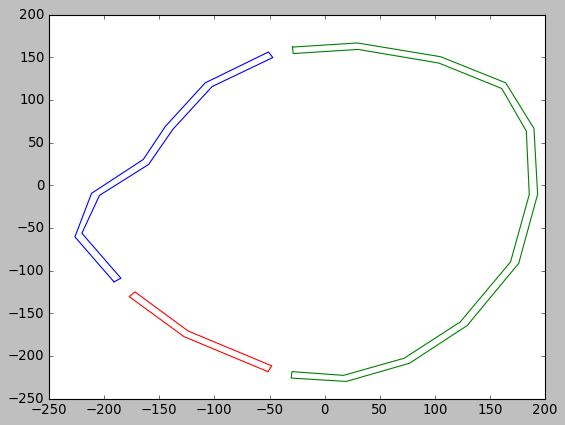

In [11]:
for seg in walls:
    xr,yr=np.array(seg).transpose()
    plt.plot(xr,yr)
#for seg in towers:
#    xr,yr=np.array(seg).transpose()
#    plt.plot(xr,yr)

1.526399316118771 1.4035992591286686


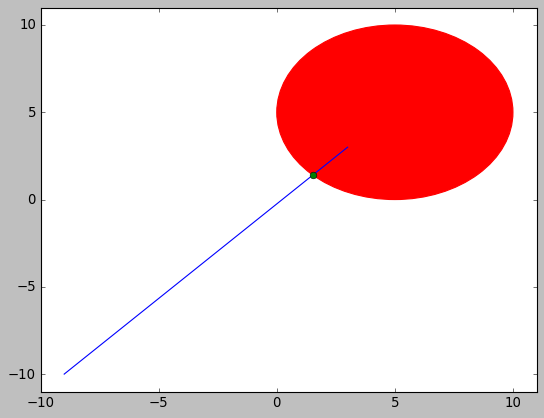

In [6]:
#make a circle centered on x,y
#radius is towerRadius
r=5
cx=5
cy=5
circle=plt.Circle((cx, cy), r, color='r')

x1=-10+1
y1=-10
x2=3

y2=3

fig, ax = plt.subplots()
ax.set_xlim((min(x1,min(x2,cx-r))-1, max(x1,max(x2,cx+r))+1))
ax.set_ylim((min(y1,min(y2,cy-r))-1, max(y1,max(y2,cy+r))+1))

ax.add_artist(circle)
plt.plot([x1,x2],[y1,y2])

 
def lineCircleIntersect(r,cx,cy,x1,y1,x2,y2):
    '''
    line defined by x1,x2,y1,y2
    circle defined by cx,cy,r
    returns None if no intersection
    returns [xr,yr] intersection point
    '''
    dx=(x1-x2)
    dy=(y1-y2)
    a=dx*dx+dy*dy
    b=2*(dx*(x2-cx)+dy*(y2-cy))
    c= cx*cx+cy*cy + x2*x2+y2*y2 -2*cx*x2-2*cy*y2 -r*r
    delta=b*b-4*a*c
    
    if delta<0:
        return [None,None]
    t=(-b+np.sqrt(delta))/(2*a)
    if t>1 or t<0:
        t=(-b-np.sqrt(delta))/(2*a)
    if t>1 or t<0:
        return [None,None]
    else:
        xr=t*(x1-x2)+x2
        yr=t*(y1-y2)+y2
        return [xr,yr]
xr,yr = lineCircleIntersect(r,cx,cy,x1,y1,x2,y2)
print(xr,yr)
if not (xr==None or yr==None):
    plt.plot(xr,yr,"o",color="green")

-2.356194490192345 1.5707963267948966


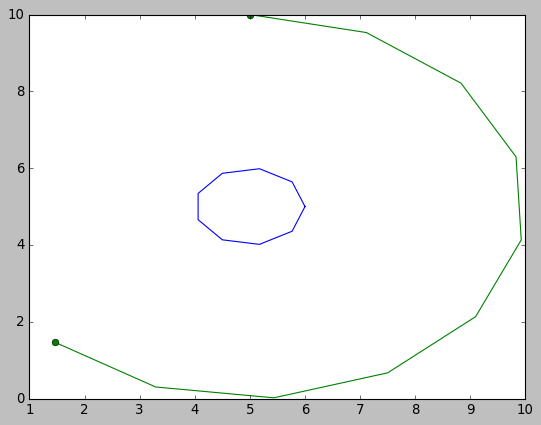

In [7]:
desiredRoundness=24
xr1,yr1 = lineCircleIntersect(5,5,5,-10,-10,3,3)
xr2,yr2 = lineCircleIntersect(5,5,5,0,10,25,10)

startAngle = np.arctan2(yr1-cy, xr1-cx)
endAngle = np.arctan2(yr2-cy, xr2-cx)

print(startAngle,endAngle)

def makeCircle(cx,cy,r,d=10):
    theta = np.linspace(0, 2*np.pi, d)
    circle = cx+r * np.cos(theta), cy+r * np.sin(theta)
    return circle

a,b=makeCircle(5,5,1)
plt.plot(a,b)    
def arcCircleFromArcAngles(t1,t2,r,cx,cy,d=10):
    ratio=abs(t2-t1)/np.pi/2
    theta = np.linspace(t1, t2, d)
    x,y=cx+r * np.cos(theta), cy+r * np.sin(theta)
    return x,y
#x,y=circleFromArc(startAngle,endAngle)
x,y=arcCircleFromArcAngles(startAngle,endAngle,r,cx,cy)
plt.plot(x,y)
#plt.plot(x2,y2)
plt.plot([xr1,xr2],[yr1,yr2],"o",color="green")

[array([ -42.13095028, -215.07797256]), array([ -43.90901251, -210.19278673]), array([ -48.41122413, -207.59343364]), array([ -53.53095028, -208.49617949]), array([ -56.8726142 , -212.47861947]), array([ -56.8726142 , -217.67732565]), array([ -53.53095028, -221.65976563]), array([ -48.41122413, -222.56251148]), array([ -43.90901251, -219.96315839]), array([ -42.13095028, -215.07797256])]


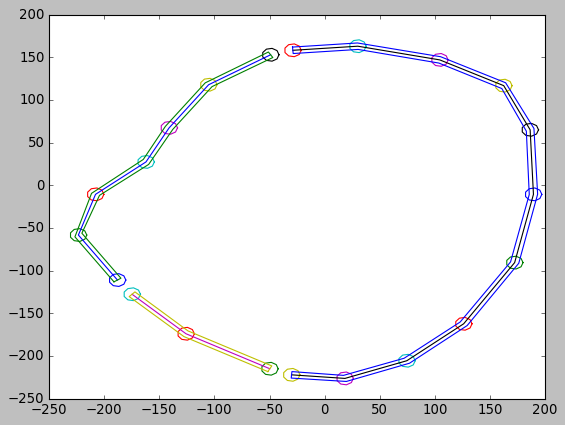

In [8]:

for seg in wallseg:
    xr,yr=np.array(seg).transpose()
    x,y=np.transpose(contourFromLine(seg,wallThickness))
    
    circles=[makeCircle(a,b,towerRadius) for a,b in zip(xr,yr)]
    for c in circles:
        plt.plot(c[0],c[1])
    plt.plot(xr,yr)
    plt.plot(x,y)
print(list(np.transpose(circles[0])))

In [9]:
tri=n=[]
wallies=walls
for seg in wallies:
#    xr,yr=np.array(seg).transpose()
#    plt.plot(xr,yr)

    if seg[0]==seg[-1]:
        seg=seg[0:-1]
    ttemp,ntemp=getCityWalls(seg,10)
    tri.append(ttemp)
    n.append(ntemp)

IndexError: invalid index to scalar variable.

In [10]:
tri=n=[]
tow=towers
for seg in tow:
    #[t.pop() for t in seg]
    if seg[0]==seg[-1]:
        seg=seg[0:-1]

    ttemp,ntemp=getCityWalls(seg,10)
    tri.append(ttemp)
    n.append(ntemp)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

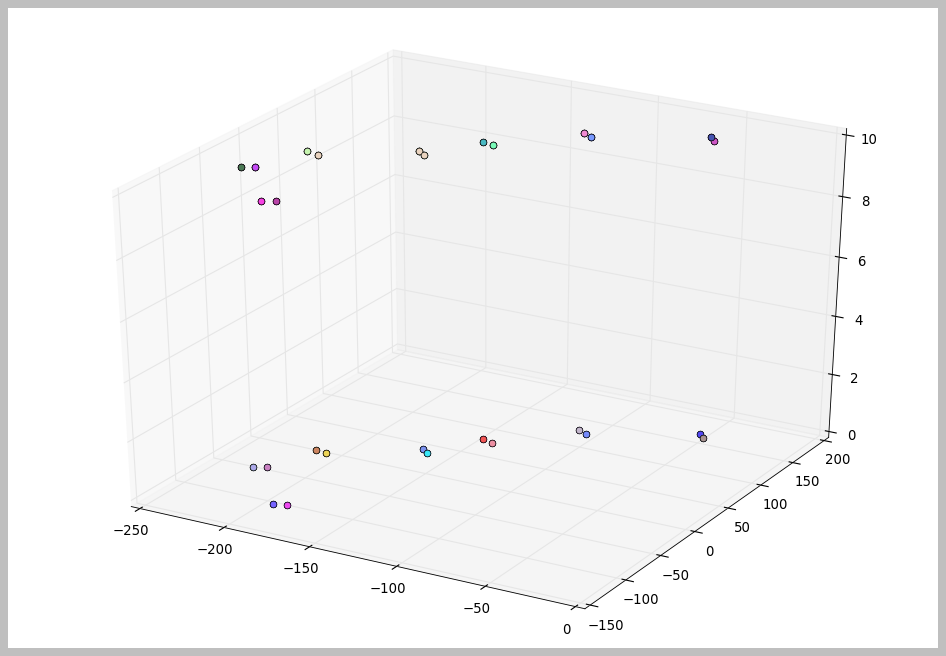

In [75]:
from mpl_toolkits.mplot3d import Axes3D as plt3
import random

fig = plt.figure()


for tr in tri[0]:
    #print(tr)
    x,y,z=np.transpose(tr)
    r=random.randint(50,256)/256
    g=random.randint(50,256)/256
    b=random.randint(50,256)/256

    ax = fig.gca(projection='3d')
    plt.gcf().set_size_inches(15,10) 

    ax.plot(x,y,z,"o",color=[r,g,b])#,depthshade=False)
    

wallstriN

###### 

In [ ]:
print(len(tow))
print(len(tow[0]))
print(len(tow[0][0]))

In [ ]:
print(len(walls))
print(len(walls[0]))
print(len(walls[0][0]))